In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans

# df_raw = pd.read_csv('spotify_song_output.csv')

# df_raw.head()

In [71]:
row, col = df_raw.shape
print(f'There are {row} rows and {col} columns')

song_raw_copy = df_raw.copy()

There are 2305616 rows and 14 columns


In [72]:
# Reducing the num of columns of the dataset using PCA (13 -> 2)
def pca(df):
    # Extract and store track_uri values
    track_uris = df['track_uri'].values
    
    # Drop the track_uri column from the dataframe
    df_numeric = df.drop('track_uri', axis=1)

    # Apply PCA
    pca_init = PCA(n_components=2)
    pca_result = pca_init.fit_transform(df_numeric)
    
    # Combine PCA results with original track_uri values
    result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    result_df['track_uri'] = track_uris
    
    # Display PCA components
    pca_dataset = pd.DataFrame(abs(pca_init.components_), columns=df_numeric.columns, index=['PC1', 'PC2'])
    print('\n\n', pca_dataset)
    
    print('\n Most Important Features')
    print('PC1: ', (pca_dataset[pca_dataset > 0.3].iloc[0]).dropna())
    print('PC2: ', (pca_dataset[pca_dataset > 0.3].iloc[1]).dropna())
    
    return result_df, pca_init

    

In [78]:
def pca_manual(df):
    # Extract and store track_uri values
    track_uris = df['track_uri'].values
    
    # Drop the track_uri column from the dataframe
    df_numeric = df.drop('track_uri', axis=1)

    # Apply PCA
    pca_init = PCA(n_components=4)
    pca_result = pca_init.fit_transform(df_numeric)
    
    # Combine PCA results with original track_uri values
    result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    result_df['track_uri'] = track_uris
    
    # Display PCA components
    pca_dataset = pd.DataFrame(abs(pca_init.components_), columns=df_numeric.columns, index=['PC1', 'PC2'])
    print('\n\n', pca_dataset)
    
    print('\n Most Important Features')
    print('PC1: ', (pca_dataset[pca_dataset > 0.3].iloc[0]).dropna())
    print('PC2: ', (pca_dataset[pca_dataset > 0.3].iloc[1]).dropna())
    print('PC3: ', (pca_dataset[pca_dataset > 0.3].iloc[2]).dropna())
    print('PC4: ', (pca_dataset[pca_dataset > 0.3].iloc[3]).dropna())
    
    return result_df, pca_init

In [73]:
# Using silhouette score method to see how many clusters works best
def kmeans_cluster_tuning(data):
    if 'track_uri' in data.columns:
        data = data.drop('track_uri', axis=1)
        
    #Taking random sample as dataset is too large    
    random_sample = data.sample(frac=0.03, replace=False, random_state=1) 
    
    cluster_options = [2,3,4,5,10,15,20,25,30]
    parameter_grid = ParameterGrid({'n_clusters': cluster_options})
    
    best_score = -1
    kmeans = KMeans()
    silhouette_scores = []
    
    for param in parameter_grid:
        kmeans.set_params(**param)
        kmeans.fit(random_sample)
        
        sil_score = metrics.silhouette_score(random_sample, kmeans.labels_) #calculates the silhouette score
        silhouette_scores += [sil_score] 
        
        if sil_score > best_score:
            best_score = sil_score
            best_grid = param
            
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(cluster_options))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()

    return best_grid['n_clusters']



In [74]:
# visualizations 
def visualizing_results(pca_result, label, centroids_pca):
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    plt.scatter(x, y, c=label, alpha=0.5, s=200)
    plt.title('Song Attribute Clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

    plt.show()
    


In [75]:
# def main():
#     print("\n\n2. Reducing via PCA\n")
#     pca_result, pca_2 = pca(song_raw_copy)

#     print("\n\n3. HyperTuning the Parameter for KMeans\n")
#     optimum_num_clusters = kmeans_cluster_tuning(song_raw_copy)
#     print("optimum num of clusters =", optimum_num_clusters)

#     kmeans = KMeans(n_clusters=optimum_num_clusters)
#     kmeans.fit(song_raw_copy)
#     centroids = kmeans.cluster_centers_
#     centroids_pca = pca_2.transform(centroids)

#     print("\n\n4. Visualizing the data")
#     visualizing_results(pca_result, kmeans.labels_, centroids_pca)
    
    
# if __name__ == "__main__":
#     main()
    
    
def main(song_raw_copy):
    print("\n\n2. Reducing via PCA\n")
    pca_result, pca_2 = pca(song_raw_copy)
    pca_result = pca_result.to_numpy()

    print("\n\n3. HyperTuning the Parameter for KMeans\n")
    optimum_num_clusters = kmeans_cluster_tuning(song_raw_copy)
    print("optimum num of clusters =", optimum_num_clusters)

    track_uris = song_raw_copy['track_uri'].copy()
    if 'track_uri' in song_raw_copy.columns:
        song_raw_copy = song_raw_copy.drop('track_uri', axis=1)

    kmeans = KMeans(n_clusters=optimum_num_clusters)
    kmeans.fit(song_raw_copy)
    centroids = kmeans.cluster_centers_
    centroids_pca = pca_2.transform(centroids)

    cluster_df = pd.DataFrame({'track_uri': track_uris, 'cluster_label': kmeans.labels_})

    print("\n\n4. Visualizing the data")
    visualizing_results(pca_result, kmeans.labels_, centroids_pca)

    return cluster_df






2. Reducing via PCA



      acousticness  danceability  duration_ms        energy  instrumentalness  \
PC1  9.275456e-08  8.032739e-08     1.000000  9.773178e-09      2.810733e-07   
PC2  2.446728e-03  4.235490e-07     0.000002  2.135773e-03      5.691453e-04   

              key      liveness  loudness          mode   speechiness  \
PC1  2.588606e-08  2.923215e-08  0.000002  1.083833e-07  2.598248e-08   
PC2  1.058056e-03  8.908196e-05  0.040228  6.195891e-05  1.716533e-07   

        tempo  time_signature       valence  
PC1  0.000002    6.587463e-08  2.685122e-07  
PC2  0.999184    8.308553e-04  1.039001e-03  

 Most Important Features
PC1:  duration_ms    1.0
Name: PC1, dtype: float64
PC2:  tempo    0.999184
Name: PC2, dtype: float64


3. HyperTuning the Parameter for KMeans



/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.wa

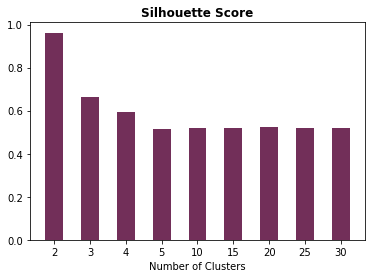

optimum num of clusters = 2


/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(




4. Visualizing the data


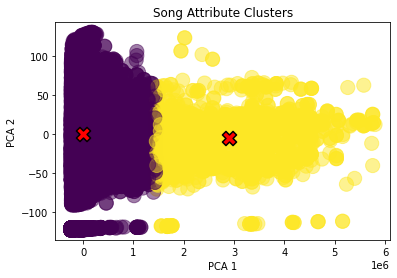

,track_uri,cluster_label
0,6LYE1PaRLikDNXR9mhzbOI,0
1,4K1qWaIbNiK12HhAskig13,0
2,3r8WJiwg0M4oL72SB1GgAM,0
3,4vJc4hG7MLFg9z0Hx9t309,0
4,0EQP6c8OtXw4tG2VszjSVz,0
...,...,...
2305611,4a94JpaqEygzgIkeIrCZCR,0
2305612,2KkmrxkwGMzJV6ZxRSjSOH,0
2305613,3RFNZ1Hd2qWdGg4WdTrZcO,0
2305614,2qUQN66FpMr2eXwhvKfAD6,0


In [76]:
df_raw = pd.read_csv('spotify_song_output.csv')
song_raw_copy = df_raw.copy()

main(song_raw_copy)



2. Reducing via PCA



      acousticness  danceability  duration_ms        energy  instrumentalness  \
PC1  9.275456e-08  8.032739e-08     1.000000  9.773178e-09      2.810733e-07   
PC2  2.446728e-03  4.235490e-07     0.000002  2.135773e-03      5.691453e-04   

              key      liveness  loudness          mode   speechiness  \
PC1  2.588606e-08  2.923215e-08  0.000002  1.083833e-07  2.598248e-08   
PC2  1.058056e-03  8.908196e-05  0.040228  6.195891e-05  1.716533e-07   

        tempo  time_signature       valence  
PC1  0.000002    6.587463e-08  2.685122e-07  
PC2  0.999184    8.308553e-04  1.039001e-03  

 Most Important Features
PC1:  duration_ms    1.0
Name: PC1, dtype: float64
PC2:  tempo    0.999184
Name: PC2, dtype: float64


3. HyperTuning the Parameter for KMeans



/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.wa

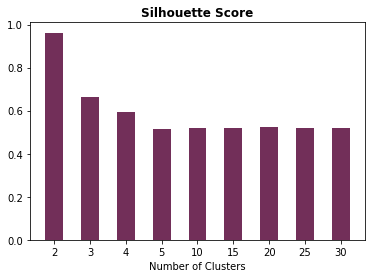

optimum num of clusters = 2


/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/julialee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(




4. Visualizing the data


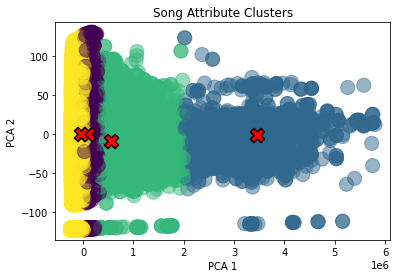

,track_uri,cluster_label
0,6LYE1PaRLikDNXR9mhzbOI,3
1,4K1qWaIbNiK12HhAskig13,3
2,3r8WJiwg0M4oL72SB1GgAM,3
3,4vJc4hG7MLFg9z0Hx9t309,3
4,0EQP6c8OtXw4tG2VszjSVz,3
...,...,...
2305611,4a94JpaqEygzgIkeIrCZCR,3
2305612,2KkmrxkwGMzJV6ZxRSjSOH,3
2305613,3RFNZ1Hd2qWdGg4WdTrZcO,3
2305614,2qUQN66FpMr2eXwhvKfAD6,0


In [81]:
def main_manual(song_raw_copy):
    print("\n\n2. Reducing via PCA\n")
    pca_result, pca_2 = pca(song_raw_copy)
    pca_result = pca_result.to_numpy()

    print("\n\n3. HyperTuning the Parameter for KMeans\n")
    optimum_num_clusters = kmeans_cluster_tuning(song_raw_copy)
    print("optimum num of clusters =", optimum_num_clusters)

    track_uris = song_raw_copy['track_uri'].copy()
    if 'track_uri' in song_raw_copy.columns:
        song_raw_copy = song_raw_copy.drop('track_uri', axis=1)

    kmeans = KMeans(n_clusters=4)
    kmeans.fit(song_raw_copy)
    centroids = kmeans.cluster_centers_
    centroids_pca = pca_2.transform(centroids)

    cluster_df = pd.DataFrame({'track_uri': track_uris, 'cluster_label': kmeans.labels_})

    print("\n\n4. Visualizing the data")
    visualizing_results(pca_result, kmeans.labels_, centroids_pca)

    return cluster_df

main_manual(song_raw_copy)